# DSCI-508 Determining Trade Union Status - A Final Project
### Matt Snyder

In [1]:
import pandas as pd
import os  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score

## Load Data

In [2]:
df = pd.read_csv('Matthew-TRAIN.csv')
df.head()

,TrueID,SetID,gender,Management,USAcitizen,Married,MonthsInUnion,ContinuingEd,StateOfResidence,Connectivity,...,FeatureC,FeatureD,FeatureE,FeatureF,DuesFrequency,PaperlessBilling,PaymentMethod,MonthlyDues,TotalDues,LeftUnion
0,2453,Kelby1-17547,Male,0,Yes,Yes,28,Yes,IL,Fiber optic,...,No,No,Yes,Yes,One year,No,Electronic check,106.10,2847.4,Yes
1,4992,Kelby2-15008,Female,0,Yes,Yes,6,Yes,MO,DSL,...,No,No,No,No,Month-to-month,No,Mailed check,45.50,285.2,No
2,4909,Kelby3-15091,Female,0,Yes,No,71,Yes,IL,No,...,Maryville,Maryville,Maryville,Maryville,Two year,No,Mailed check,23.85,1672.1,No
3,6612,Kelby4-13388,Male,0,No,No,5,Yes,MO,Fiber optic,...,No,No,Yes,No,Month-to-month,Yes,Mailed check,80.10,398.55,No
4,1952,Kelby5-18048,Male,0,Yes,No,65,Yes,IL,Fiber optic,...,No,No,Yes,No,Month-to-month,Yes,Bank transfer (automatic),91.85,5940.85,Yes


## Cleanse and Normalize

### Cleanse Entries
Make a histogram of every feature, not including the ID fields, to check for anomolous entries, such as misspellings, or the same thing represented two ways.  I did not find anything that needed cleansing

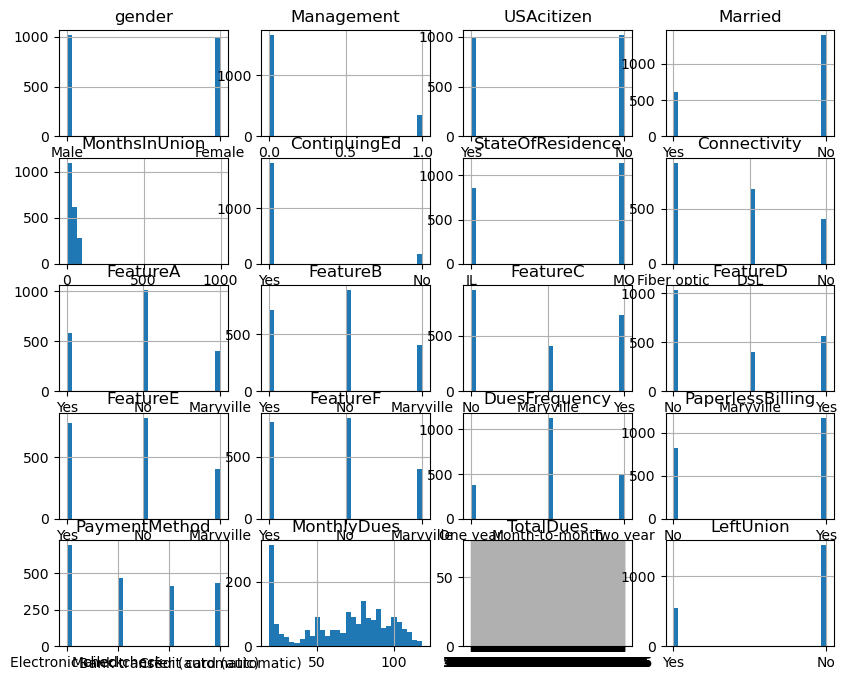

In [3]:
plt.figure(figsize=[10,8])
for i in range(2, len(df.columns)):
    plt.subplot(5,4,i-1)
    df.iloc[:, i].hist(bins=30)
    plt.title(df.columns[i])
plt.show()

### Cleanse Column Types
Look for columns that are object but should be numeric.  TotalDues is object.  When I tried to convert it to float, I discovered why: some entries contain spaces

In [4]:
df.dtypes

TrueID                int64
SetID                object
gender               object
Management            int64
USAcitizen           object
Married              object
MonthsInUnion         int64
ContinuingEd         object
StateOfResidence     object
Connectivity         object
FeatureA             object
FeatureB             object
FeatureC             object
FeatureD             object
FeatureE             object
FeatureF             object
DuesFrequency        object
PaperlessBilling     object
PaymentMethod        object
MonthlyDues         float64
TotalDues            object
LeftUnion            object
dtype: object

In [5]:
# this gives error: df['TotalDues'] = df['TotalDues'].astype(float)
df['TotalDues'] = pd.to_numeric(df['TotalDues'], errors='coerce')
df.dtypes

TrueID                int64
SetID                object
gender               object
Management            int64
USAcitizen           object
Married              object
MonthsInUnion         int64
ContinuingEd         object
StateOfResidence     object
Connectivity         object
FeatureA             object
FeatureB             object
FeatureC             object
FeatureD             object
FeatureE             object
FeatureF             object
DuesFrequency        object
PaperlessBilling     object
PaymentMethod        object
MonthlyDues         float64
TotalDues           float64
LeftUnion            object
dtype: object

### Normalize Numeric Features
First look for strong correlation between the features, which would allow me to quickly reduce dimensions.  I used the pairplot function of Seaborn.  I am also looking for predictors of the target.

Things that I observed:
* Months in Union is heavily clustered under 100, with only a handful of outliers. It appears that 60% of the outliers left the union, which differs from the overall tendency of only 27%, so there might be some predictive value.  Or, I could just ignore the outliers, by truncating those above 100 to 100.  I think I will truncate, and then normalize to numbers between 0 and 1 by dividing by 100.
* For each feature, the distribution is similar between left the union and did not.
* TotalDues is correlated with two other feaures: MonthlyDues and MonthsInUnion. It makes sense that TotalDues is an integral over MonthsInUnion of MonthlyDues, so there will be a correlation of some kind.  I think it would be possible to calculate the covariance, and prove that TotalDues redundant with the other two.  Because we have figured out a plan to normalize the other two, I will omit TotalDues from the model.
* Monthly dues are not uniformly distributed, and not normally either.  There are two peaks, looks like around 25 and 80.  I could convert all these numbers to 0 or 1, representing dues closer to 25 or dues closer to 80.  I think instead, I will normalize MonthlyDues to be in the range 0 to 1, by dividing by the max, which looks like 120.
* The montly dues peak at 25 is only present on the distribution of those who stayed in the union.  So I would expect monthly dues to be an important feature for prediction leave vs. stay.

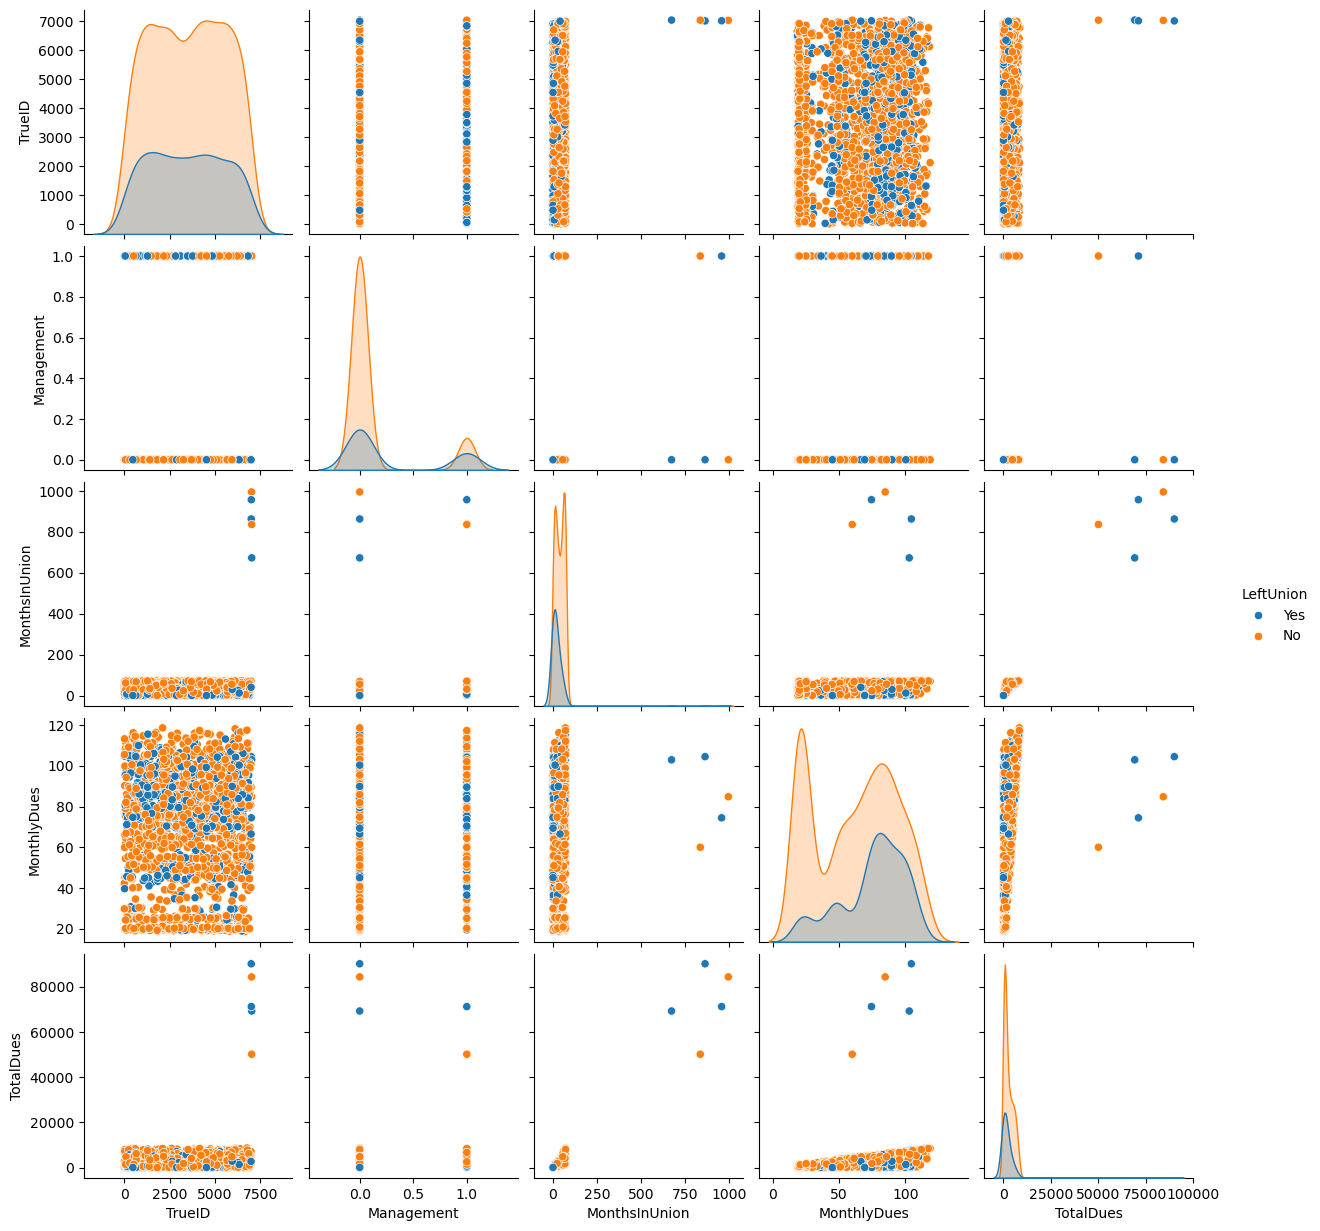

In [6]:
sns.pairplot(df, hue="LeftUnion")
plt.show()

Percentage distribution of LeftUnion

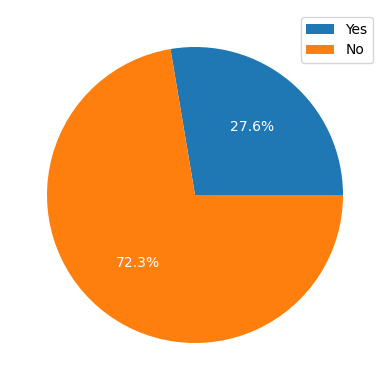

In [7]:
dist = df["LeftUnion"].value_counts().to_dict()
fig = plt.figure(figsize = (4,4))
ax = fig.add_subplot()
dist_sorted = sorted(dist.items(), reverse=True) # sort dictionary to get colors of No and Yes to match above charts
dist = dict(dist_sorted)
ax.pie(dist.values(), labels = dist.keys(), autopct = '%1.1f%%', textprops = {'fontsize': 10, 'color' : "white"})
plt.tight_layout()
plt.legend()
plt.show()

Normalize Dues

In [8]:
df['MonthlyDues_norm'] = np.clip(df['MonthlyDues'].values, 0, 120) / 120

Normalize MonthsInUnion

In [9]:
df['MonthsInUnion_norm'] = np.clip(df['MonthsInUnion'].values, 0, 100) / 100

### Normalize Categorical Features

In [10]:
col_list = list( df.columns)
objList = []
for col in col_list:
    if df.dtypes[col] == object:
        objList.append(col)
objList

['SetID',
 'gender',
 'USAcitizen',
 'Married',
 'ContinuingEd',
 'StateOfResidence',
 'Connectivity',
 'FeatureA',
 'FeatureB',
 'FeatureC',
 'FeatureD',
 'FeatureE',
 'FeatureF',
 'DuesFrequency',
 'PaperlessBilling',
 'PaymentMethod',
 'LeftUnion']

Skip SetID at beginning, and LeftUnion at end

In [36]:
# create columns for every possible categorical value
df_cats = pd.get_dummies(df[objList[1:-1]], prefix_sep='_', drop_first=False) # 1-hot, not triangular

# _Yes and _No column pairs are correlated and redundant, so remove the _No columns if there is also a _Yes column
column_list = list(df_cats.columns)
cleaner_column_list = [column for column in column_list if '_No' not in column or column.replace('_No', '_Yes') not in column_list]
df_cats = df_cats.loc[:, cleaner_column_list]
print (cleaner_column_list)

df_cats.head()

['gender_Female', 'gender_Male', 'USAcitizen_Yes', 'Married_Yes', 'ContinuingEd_Yes', 'StateOfResidence_IL', 'StateOfResidence_MO', 'Connectivity_DSL', 'Connectivity_Fiber optic', 'Connectivity_No', 'FeatureA_Maryville', 'FeatureA_Yes', 'FeatureB_Maryville', 'FeatureB_Yes', 'FeatureC_Maryville', 'FeatureC_Yes', 'FeatureD_Maryville', 'FeatureD_Yes', 'FeatureE_Maryville', 'FeatureE_Yes', 'FeatureF_Maryville', 'FeatureF_Yes', 'DuesFrequency_Month-to-month', 'DuesFrequency_One year', 'DuesFrequency_Two year', 'PaperlessBilling_Yes', 'PaymentMethod_Bank transfer (automatic)', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']


,gender_Female,gender_Male,USAcitizen_Yes,Married_Yes,ContinuingEd_Yes,StateOfResidence_IL,StateOfResidence_MO,Connectivity_DSL,Connectivity_Fiber optic,Connectivity_No,...,FeatureF_Maryville,FeatureF_Yes,DuesFrequency_Month-to-month,DuesFrequency_One year,DuesFrequency_Two year,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,False,True,True,True,True,True,False,False,True,False,...,False,True,False,True,False,False,False,False,True,False
1,True,False,True,True,True,False,True,True,False,False,...,False,False,True,False,False,False,False,False,False,True
2,True,False,True,False,True,True,False,False,False,True,...,True,False,False,False,True,False,False,False,False,True
3,False,True,False,False,True,False,True,False,True,False,...,False,False,True,False,False,True,False,False,False,True
4,False,True,True,False,True,True,False,False,True,False,...,False,False,True,False,False,True,True,False,False,False


### Combine the dataframes

In [37]:
X_df = pd.concat([df.loc[:, ['MonthsInUnion_norm', 'MonthlyDues_norm']], df_cats],axis=1)
X_df.head()

,MonthsInUnion_norm,MonthlyDues_norm,gender_Female,gender_Male,USAcitizen_Yes,Married_Yes,ContinuingEd_Yes,StateOfResidence_IL,StateOfResidence_MO,Connectivity_DSL,...,FeatureF_Maryville,FeatureF_Yes,DuesFrequency_Month-to-month,DuesFrequency_One year,DuesFrequency_Two year,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0.28,0.884167,False,True,True,True,True,True,False,False,...,False,True,False,True,False,False,False,False,True,False
1,0.06,0.379167,True,False,True,True,True,False,True,True,...,False,False,True,False,False,False,False,False,False,True
2,0.71,0.198750,True,False,True,False,True,True,False,False,...,True,False,False,False,True,False,False,False,False,True
3,0.05,0.667500,False,True,False,False,True,False,True,False,...,False,False,True,False,False,True,False,False,False,True
4,0.65,0.765417,False,True,True,False,True,True,False,False,...,False,False,True,False,False,True,True,False,False,False


In [38]:
y_df = df[['LeftUnion']]
y = y_df.values
y_df.head()

,LeftUnion
0,Yes
1,No
2,No
3,No
4,Yes


## Modeling and Predicting

### Decision Tree

Divide training data into train and test, 80% / 20%

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2, random_state=0)

**Train model**

In [40]:
clf=tree.DecisionTreeClassifier(max_leaf_nodes=None, criterion='gini')
clf=clf.fit(X_train,y_train)

**Make predictions, evaluate accuracy**

In [41]:
predictions = clf.predict(X_train)
accuracy_train = (predictions == y_train[:, 0]).sum() / len(predictions)
predictions = clf.predict(X_test)
accuracy_test = (predictions == y_test[:, 0]).sum() / len(predictions)
print (f'accuracy with training data: {accuracy_train}')
print (f'accuracy with test data:     {accuracy_test}')

accuracy with training data: 0.999375
accuracy with test data:     0.7625


**Conclusion:** accuracy of the decision tree model is very good with training data, but poor with test data, which is indicative of overtraining.  I experimented with different values for max_leaf_nodes, but the resulting accuracy was never better than 82%

In [42]:
clf2=tree.DecisionTreeClassifier(max_leaf_nodes=10, criterion='gini')
clf2=clf2.fit(X_train,y_train)

In [43]:
predictions = clf2.predict(X_train)
accuracy_train = (predictions == y_train[:, 0]).sum() / len(predictions)
predictions = clf2.predict(X_test)
accuracy_test = (predictions == y_test[:, 0]).sum() / len(predictions)
print (f'accuracy with training data: {accuracy_train}')
print (f'accuracy with test data:     {accuracy_test}')

accuracy with training data: 0.806875
accuracy with test data:     0.8125


**Obtain feature importance from the model**

In [44]:
importances = clf2.feature_importances_
feature_importances = pd.Series(importances, index=X_train.columns)
print(feature_importances.sort_values(ascending=False)[0:10])

DuesFrequency_Month-to-month    0.550154
MonthsInUnion_norm              0.202142
Connectivity_Fiber optic        0.141141
PaperlessBilling_Yes            0.038444
FeatureD_Yes                    0.022951
FeatureF_Maryville              0.022631
Married_Yes                     0.022536
gender_Female                   0.000000
StateOfResidence_IL             0.000000
StateOfResidence_MO             0.000000
dtype: float64


**Try using just the top 2 features in the decision tree**

In [45]:
X_train_r = X_train.loc[:, ['MonthsInUnion_norm', 'DuesFrequency_Month-to-month']]
X_test_r = X_test.loc[:, ['MonthsInUnion_norm', 'DuesFrequency_Month-to-month']]
X_train_r.head()

,MonthsInUnion_norm,DuesFrequency_Month-to-month
582,0.22,True
159,0.14,False
1827,0.27,True
318,0.32,True
708,0.09,True


In [46]:
# train
clf3=tree.DecisionTreeClassifier(max_leaf_nodes=None, criterion='gini')
clf3=clf3.fit(X_train_r,y_train)
# test
predictions = clf3.predict(X_train_r)
accuracy_train = (predictions == y_train[:, 0]).sum() / len(predictions)
predictions = clf3.predict(X_test_r)
accuracy_test = (predictions == y_test[:, 0]).sum() / len(predictions)
print (f'accuracy with training data: {accuracy_train}')
print (f'accuracy with test data:     {accuracy_test}')

accuracy with training data: 0.769375
accuracy with test data:     0.745


**Look at relationship between the top two features**
The initial pair plot compared only numeric features, not categorical ones.  Do a new pair plot with the top features

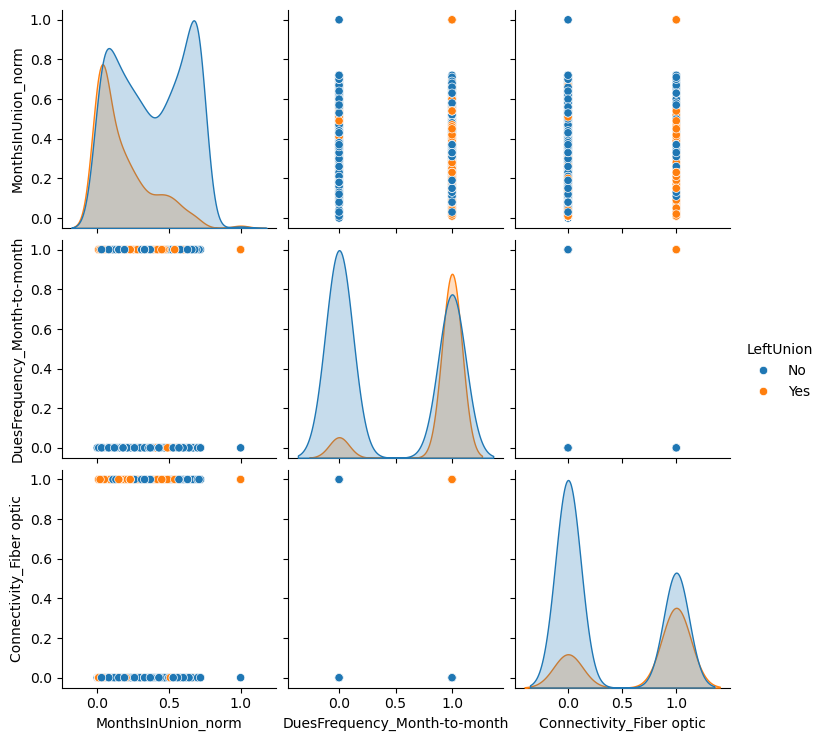

In [55]:
X_for_new_pair_plot = X_train.loc[:, ['MonthsInUnion_norm', 'DuesFrequency_Month-to-month', 'Connectivity_Fiber optic']]
X_for_new_pair_plot['LeftUnion'] = y_train[:, 0]
X_for_new_pair_plot.head()
sns.pairplot(X_for_new_pair_plot, hue="LeftUnion")
plt.show()

y_train[:, 0]

**Explore the apparently correlation between Dues Frequency and Connectivity**
The distribution of leavers and stayers is similar between them, i.e. more leavers are month-to-month, and more leavers have fiber.  See if the two are directly correlated.

In [63]:
# count the number of members with combinations of the dues and connectivity values
combo_matrix = []
combo_matrix.append([x[0] and x[1] for x in X_for_new_pair_plot.loc[:, ['DuesFrequency_Month-to-month', 'Connectivity_Fiber optic']].values])
combo_matrix.append([x[0] and not x[1] for x in X_for_new_pair_plot.loc[:, ['DuesFrequency_Month-to-month', 'Connectivity_Fiber optic']].values])
combo_matrix.append([not x[0] and x[1] for x in X_for_new_pair_plot.loc[:, ['DuesFrequency_Month-to-month', 'Connectivity_Fiber optic']].values])
combo_matrix.append([not x[0] and not x[1] for x in X_for_new_pair_plot.loc[:, ['DuesFrequency_Month-to-month', 'Connectivity_Fiber optic']].values])
labels = ['M to M and Fiber', 'M to M and no Fiber', 'not M to M and Fiber', 'not M to M and no Fiber']
sums = np.sum(combo_matrix, axis=1)

array([530, 385, 200, 485])

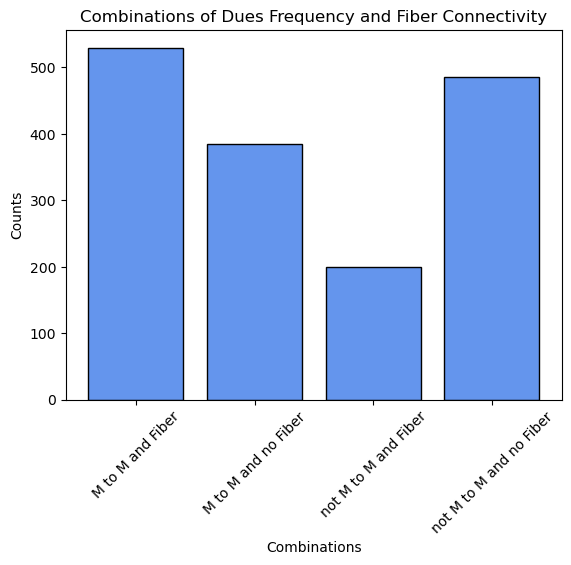

In [66]:
# Make a bar chart of the combinations
plt.bar(x=labels, height=sums, color='cornflowerblue', edgecolor='black')
plt.xlabel('Combinations')
plt.xticks(rotation=45)
plt.ylabel('Counts')
plt.title('Combinations of Dues Frequency and Fiber Connectivity')
plt.show()

**Conclusion:** The model is not as good using only the top two features, *MonthsInUnion* and *DuesFrequency*, but it is still surprisingly good.  And it is maybe intuitive, that the dues payment schedule might influence lapsing.  In this case, you might conclude that people are leaving the union not intentionally, but accidentally when they just neglect to pay dues.  

Also, this second pair plot and the first one both hilighted the different distribution of montly dues between leavers and stayers, which suggested montly dues would be a significant feature for prediction, and it was.   This second pair plot also shows a different density for dues frequency: more of the leavers were on a month-to-month dues schedule, which suggests dues frequency would be significant for prediction, and it was.

The second pair plot suggested a possible correlation between dues frequency and fiber connectivity, and so I compared them by count, and the counts suggest a mild correlation: the features are matched, month-to-month = fiber, more often than they are mismatched.  But since it is not a overwhelming correlation, we would have to calculate the coveriance in order to remove one of them.